# Práctica 2 - Clasificación supervisada en scikit-learn

## Minería de Datos 2017/2018 - Francisco Martínez Esteso

---

# Indice de Contenido

* [Introducción](#Introducción)
    * [Paquetes y librerías](#Paquetes-y-librerías)
    * [Carga de datos](#Carga-de-datos)
* [GridSearch](#GridSearch)
    * [Clasificador KNN](#Clasificador-KNN)
        * [Pima Dataset](#Pima-Dataset)
        * [Iris Dataset](#Iris-Dataset)
        * [Wisconsin Dataset](#Wisconsin-Dataset)

---
# Introducción

En esta segunda práctica de la asignatura de Minería de Datos vamos a ejecutar e implementar algoritmos de selección de modelos que buscan soluciones óptimas a problemas de hyperparametrización, más concretamente el algoritmo `GridSearch` y su descendiente `RandomizedSearchCV`.

Para ello y siguiendo el guión de la práctica, empezaremos ejecutando e investigando los algoritmos presentados `knn` y `DecisionTreeClassifier` para conocer su parametrización y obtener conclusiones frente a algunos casos de prueba. 

A continuación ejecutaremos el algoritmo de búsqueda de hyperparámetros `gridSearchCV` para obtener configuraciones óptimas de parámetros para los algoritmos anteriores. También en este apartado compararemos los resultados y trataremos de entender y explicar sus fornteras de decisión, apoyándonos en los gráficos que nos proporcionan las librerías para generar gráficos de fronteras de decisión y árboles de decisión.

Por último tratamos de entender la metodología sobre la que trabaja un algoritmo de `GridSearchCV` para implementar de manera manual y autónoma el mismo algoritmo, primero para **knn** y a continuación para **DecisionTreeClassifier**.

---
## Paquetes y librerías

Cargamos previamente todos los paquetes y librarías necesarios:

In [187]:
import numpy as np
import pandas as pd
from scipy import stats, integrate
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import seaborn as sns
sns.set(color_codes=True)

# GridSearch
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# KNN
from sklearn import neighbors

# Metrics
import sklearn.metrics as metrics

# Árbol de decisión
from sklearn import tree

# Pipeline, Imputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer

In [188]:
%matplotlib inline
mpl.rcParams["figure.figsize"] = "8, 4"
import warnings
warnings.simplefilter("ignore")

---
## Carga de datos

En esta práctica usaremos como datasets los ficheros `CSV`proporcionados en campusvirtual `iris`, `pima` y `wisconsin`. 
Definimos una semilla inicial, la cual nos será útil para hacer **reproducibles** nuestros experimentos.
También con el fin de hacer nuestra libreta reproducible y adaptable a otros datasets hemos definido todo el proceso de creación de variables del dataset en una función `definirDataset(..)` que especificamos a continuación:

```
definirDataset(
    datasetname: Nombre del dataset a importar o definir.
)
```

**_Output_**:
* **df**: Dataset completo.
* **dfAttributes**: Atributos o variables del dataset.
* **dfLabel**: Variable clase del dataset.
* **train_atts**: Atributos o variables del conjunto de entrenamiento.
* **test_atts**: Atributos o variables del conjunto de test.
* **train_label**: Variable clase del conjunto de entrenamiento.
* **test_label**: Variable clase del conjunto de test.      

In [189]:
seed = 6342
np.random.seed(6342)

In [190]:
def definirDataset(datasetname):
    df = pd.read_csv("../data/"+datasetname+".csv", dtype={ "label": 'category'})
    
    dfAttributes = df.drop('label', 1)
    dfLabel = df['label']
    
    train_atts, test_atts, train_label, test_label = train_test_split( 
    dfAttributes,
    dfLabel,
    test_size=0.2,
    random_state=seed,
    stratify=dfLabel)
    
    return df, dfAttributes, dfLabel, train_atts, test_atts, train_label, test_label

Ejemplo de uso:

```
df, dfAttributes, dfLabel, train_atts, test_atts, train_label, test_label = definirDataset("iris")
```



---
# GridSearch

En esta primera parte de la práctica vamos a analizar el algoritmo de búsqueda de parámetros óptimos para un estimador `GridSearch`.

El algoritmo de **GridSearch** recibe un grid o cuadro de parámetros y nos permite realizar una búsqueda exhaustiva evaluando mediante validación cruzada todas las posibles combinaciones existentes.
El esquema de parametrización de GridSearch es el siguiente:
```
GridSearchCV(
    estimator # El algoritmo de aprendizaje a optimizar 
    param_grid # Un diccionario con los nombres de los parámetros y los valores a considerar
    scoring  # La métrica a optimizar
    cv # Numero de folds en la validación cruzada
)
```

## Clasificador KNN

**KNN** es un método de clasificación sencillo de entender, ya que solo tiene un parámetro **k** que determina el número de vecinos con los que compararemos.
Podemos ver un esquema de su parametrización a continuación:
```
neighbors.KNeighborsClassifier(
    n_neighbors # numero de vecinos en la clasificación
)
```

Implementamos por tanto una función en la que ejecutamos un algoritmo GridSearch de selección de modelos que usa una validación cruzada de 10 folds para optimizar el valor  óptimo de k en el algoritmo KNN, en el rango de valores [1,10]. 
Podemos ver un esquema de la estructura de nuestra función a continuación:
```
KNNgridSearchCV(
    datasetname: Nombre de la base de datos a definir.
    pintar: Valor booleano para indicar si se muestran las gráficas de las fronteras de decisión.
)
```

In [191]:
def KNNgridSearchCV(datasetname, pintar):
    
    # Definimos Dataset
    df, dfAttributes, dfLabel, train_atts, test_atts, train_label, test_label = definirDataset(datasetname)

    pipeline = Pipeline([('imputer', Imputer(missing_values='NaN',
                                            strategy='mean',
                                            axis=0)),
                         ('knn', neighbors.KNeighborsClassifier())])   
    
    # Algoritmo GridSearch
    clf = GridSearchCV(
        pipeline, 
        {'knn__n_neighbors' : range(1,11)},
        scoring = 'accuracy',
        cv = 10
    )
    
    fitted = clf.fit(train_atts, train_label)
    
    print("Parametrización óptima: \n")
    print(fitted.best_params_)
    print("\n")
    
    # Get the mean score for each cv
    means = fitted.cv_results_['mean_test_score']
    # Get the sd score for each cv
    stds = fitted.cv_results_['std_test_score']
    # Get each specific configuration
    conf = fitted.cv_results_['params']

    # Print the three things togheter
    for mean, std, params in zip(means, stds, conf):
        print("%0.3f (+/-%0.03f) for %r"
            % (mean, std * 2, params))
    print("\n")
        
    prediction = clf.predict(test_atts)
    print("Matriz de confusion: \n")
    print( metrics.confusion_matrix(test_label, prediction))
    print("\n")
    print("Accuracy o precisión: \n")
    print(metrics.accuracy_score(test_label, prediction))
    
    if pintar == True:
        model = neighbors.KNeighborsClassifier(fitted.best_params_['knn__n_neighbors'])
        classifierPrintBoundaries(model, train_atts, train_label, test_atts, test_label) 

Ahora implementamos las funciones que nos proporciona el guión de la práctica para generar un gráfico que nos permita representar las distancias, obteniendo las fronteras de decisión:

In [192]:
def classifierPrintBoundaries(model, train_atts, train_label, test_atts, test_label):

    attsPair = [ (x,y) for x in train_atts.columns for y in train_atts.columns if x != y]
    
    for (att1_name, att2_name) in attsPair:
        
        xx, yy = np.meshgrid(np.arange(min(train_atts[att1_name])-1, max(train_atts[att1_name])+1, 0.05),
                             np.arange(min(train_atts[att2_name])-1, max(train_atts[att2_name])+1, 0.05))

        mesh = pd.DataFrame({ 'x' : xx.ravel(), 'y' : yy.ravel() })
        
        cls = model.fit(train_atts[[att1_name, att2_name]], train_label)

        Z = cls.predict(mesh)
        mesh = mesh.assign( label = pd.Categorical(Z, categories=train_label.cat.categories) )

        colors = ["#4D73AB","#54A86F","#C44D54"]

        mesh = mesh.assign(colors = mesh.label.cat.codes.map(lambda x: colors[x]))
        colorBoundary = list(mesh.label.cat.codes.map(lambda x: colors[x]))
        colorObservations = list(test_label.cat.codes.map(lambda x: colors[x]))

        fig, ax = plt.subplots()
        # Plot using Seaborn
        sns.regplot(x='x', y='y', data=mesh,
                   fit_reg=False, 
                   scatter_kws={'color': colorBoundary})

        sns.regplot(x=att1_name, y=att2_name, data=test_atts,
                   fit_reg=False,
                   scatter_kws={'color': colorObservations,  'lw': 1, 'edgecolor':'#FFFFFF'}) 

---
### Pima Dataset

En esta práctica no haremos preprocesado de datos de los datasets con los que trabajamos como en la práctica uno, pero si usaremos algunas funciones ya estudiadas para recordar y ubicarnos en el dataset que tenemos entre manos y conocer algunos datos más.

In [193]:
df, dfAttributes, dfLabel, train_atts, test_atts, train_label, test_label = definirDataset("pima")
df.describe()

,preg,plas,pres,skin,insu,mass,pedi,age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


In [194]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
preg     768 non-null int64
plas     768 non-null int64
pres     768 non-null int64
skin     768 non-null int64
insu     768 non-null int64
mass     768 non-null float64
pedi     768 non-null float64
age      768 non-null int64
label    768 non-null category
dtypes: category(1), float64(2), int64(6)
memory usage: 48.9 KB


Como vemos la base de datos `pima` cuenta con un total de 8 variables `preg`,`plas`,`skin`,`insu`,`mass`,`pedi`,`age` y una variable clase `label`.
Todas ellas cuentan con 768 registros por lo que no observamos datos perdidos o outliers.

Tras este breve pre-análisis pasamos a ejecutar el algoritmo de búsqueda GridSearch para encontrar los parámetros óptimos para el estimador KNN:

In [195]:
KNNgridSearchCV("pima", False)
# pintar = False ---> Demasiado coste computacional y temporal.

Parametrización óptima: 

{'knn__n_neighbors': 8}


0.707 (+/-0.128) for {'knn__n_neighbors': 1}
0.717 (+/-0.049) for {'knn__n_neighbors': 2}
0.721 (+/-0.067) for {'knn__n_neighbors': 3}
0.730 (+/-0.096) for {'knn__n_neighbors': 4}
0.733 (+/-0.068) for {'knn__n_neighbors': 5}
0.731 (+/-0.059) for {'knn__n_neighbors': 6}
0.735 (+/-0.057) for {'knn__n_neighbors': 7}
0.739 (+/-0.084) for {'knn__n_neighbors': 8}
0.728 (+/-0.080) for {'knn__n_neighbors': 9}
0.739 (+/-0.080) for {'knn__n_neighbors': 10}


Matriz de confusion: 

[[90 10]
 [33 21]]


Accuracy o precisión: 

0.720779220779


Como podemos ver el algoritmo GridSearchCV nos muestra que la configuración óptima para el estimador KNN ejecutando una validación cruzada de 10 folds es `knn__n_neighbors = 8`.
Además nos proporciona la matriz de confusión en la que vemos que 43 ejemplos no han sido clasificados correctamente.
Por último nos proporciona el `accuracy` en el que obtenemos un 72% de precisión.

---
### Iris Dataset

Ejecutamos el mismo proceso con la base de datos `Iris`. Primero obtenemos algo de información del dataset con algunas funciones estudiadas:

In [196]:
df, dfAttributes, dfLabel, train_atts, test_atts, train_label, test_label = definirDataset("iris")
df.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [197]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
sepal_length    150 non-null float64
sepal_width     150 non-null float64
petal_length    150 non-null float64
petal_width     150 non-null float64
label           150 non-null category
dtypes: category(1), float64(4)
memory usage: 4.9 KB


Como vemos la base de datos cuenta con un total de 150 registros, y 4 variables predictoras (`sepal_length`,`sepal_width`,`petal_length`,`petal_width`) y una variable clase `label`. Como vemos no faltan datos perdidos o outliers.
Ejecutamos por tanto nuestro proceso de GridSerach sobre el estimador KNN para este dataset:

Parametrización óptima: 

{'knn__n_neighbors': 7}


0.958 (+/-0.083) for {'knn__n_neighbors': 1}
0.958 (+/-0.083) for {'knn__n_neighbors': 2}
0.958 (+/-0.112) for {'knn__n_neighbors': 3}
0.958 (+/-0.112) for {'knn__n_neighbors': 4}
0.958 (+/-0.112) for {'knn__n_neighbors': 5}
0.950 (+/-0.133) for {'knn__n_neighbors': 6}
0.967 (+/-0.111) for {'knn__n_neighbors': 7}
0.967 (+/-0.111) for {'knn__n_neighbors': 8}
0.967 (+/-0.111) for {'knn__n_neighbors': 9}
0.967 (+/-0.111) for {'knn__n_neighbors': 10}


Matriz de confusion: 

[[10  0  0]
 [ 0 10  0]
 [ 0  1  9]]


Accuracy o precisión: 

0.966666666667


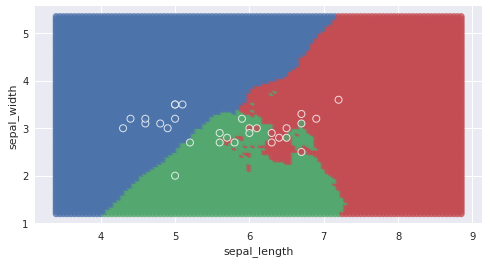

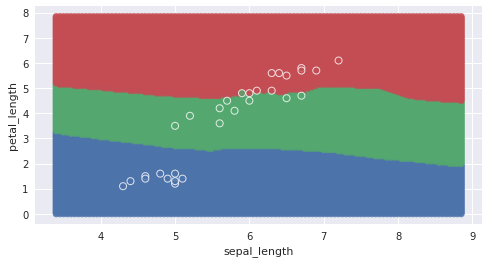

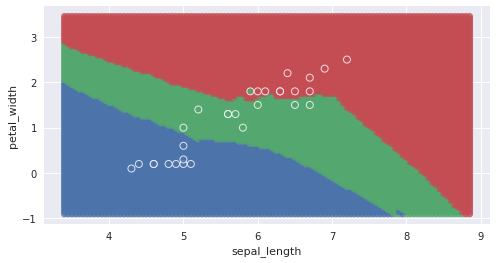

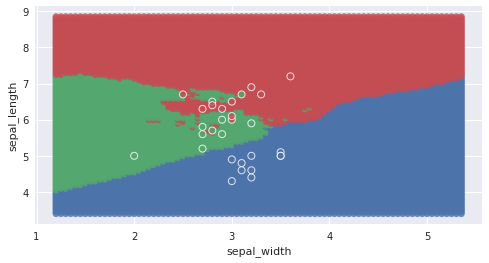

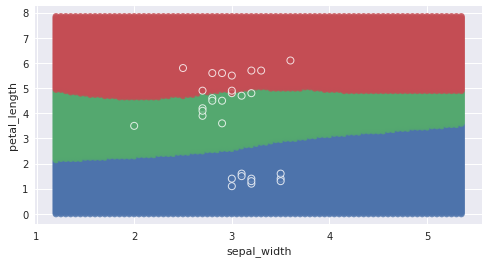

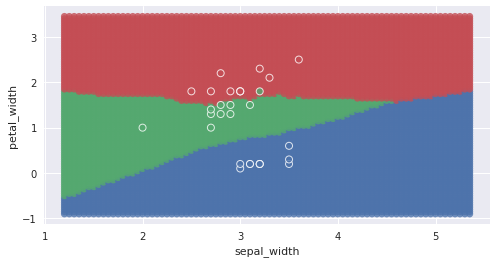

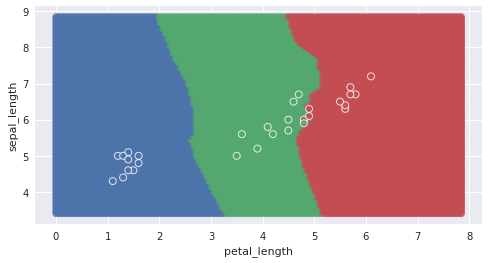

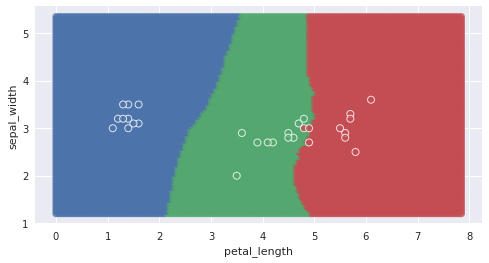

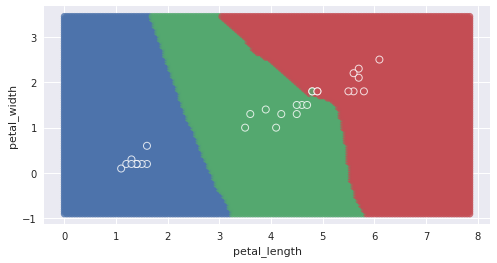

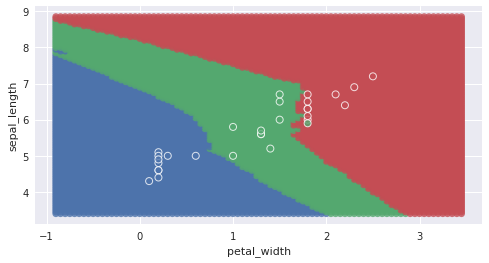

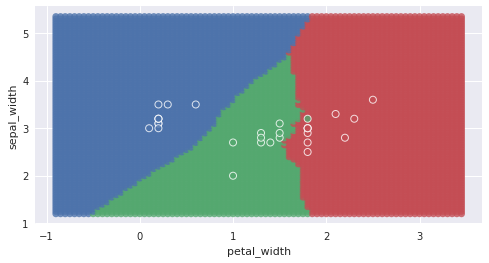

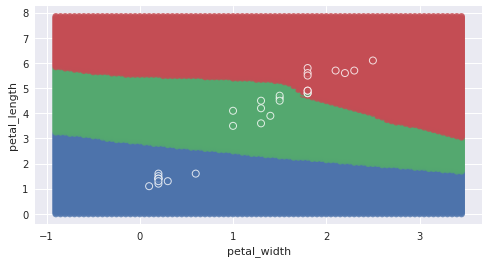

In [198]:
KNNgridSearchCV("iris", True)

Como novedad al caso anterior podemos ver que en este caso si que contamos con potencia suficiente para generar las frontera de decisión ya que la base de datos cuenta con 150 registros. Para ello ponemos el parámetro `pintar = True`.

También observamos que el algoritmo GridSearch nos arroja los resultados de `knn__n_neighbors = 7` y que únicamente clasifica mal un ejemplo en el conjunto de test. Además obtenemos un `accuracy` o precisión del 96%.

---
### Wisconsin Dataset

Como en los otros ejemplos, ejecutamos un proceso de análisis a modo de recordatorio:

In [199]:
df, dfAttributes, dfLabel, train_atts, test_atts, train_label, test_label = definirDataset("wisconsin")
df.describe()

,patientId,clumpThickness,cellSize,CellShape,marginalAdhesion,epithelialSize,bareNuclei,blandChromatin,normalNucleoli,mitoses
count,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,667.000000,699.000000,699.000000,699.000000
mean,350.000000,4.417740,3.134478,3.207439,2.806867,3.216023,3.536732,3.437768,2.866953,1.589413
std,201.928205,2.815741,3.051459,2.971913,2.855379,2.214300,3.683795,2.438364,3.053634,1.715078
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,175.500000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000
50%,350.000000,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000
75%,524.500000,6.000000,5.000000,5.000000,4.000000,4.000000,7.000000,5.000000,4.000000,1.000000
max,699.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


In [200]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
patientId           699 non-null int64
clumpThickness      699 non-null int64
cellSize            699 non-null int64
CellShape           699 non-null int64
marginalAdhesion    699 non-null int64
epithelialSize      699 non-null int64
bareNuclei          667 non-null float64
blandChromatin      699 non-null int64
normalNucleoli      699 non-null int64
mitoses             699 non-null int64
label               699 non-null category
dtypes: category(1), float64(1), int64(9)
memory usage: 55.4 KB


Como vemos la base de datos `wisconsin` actual con la que trabajamos es la más compleja de las tres, ya que además de contar con un número también alto de ejemplos (699), y con un número alto de variables (10, `patiendId`, `clumpThickness`,`cellSize`, `cellShape`, `marginalAdhesion`, `epithelialSize`, `bareNuclei`, `blandChromatin`, `normalNucleoli`, `mitoses`) y una variable clase `label`, además cuenta con valores perdidos en la variable `bareNuclei` ya que como podemos ver solo cuenta con 667 registros.

A la hora de ejecutar el algoritmo sobre la base de datos `wisconsin` debemos tener en cuenta que dicho dataset cuenta con valores perdidos o outliers, por lo que haremos un proceso de preprocesamiento de datos para imputar el valor de la media en dichos datos.
Para ello hacemos uso en la función `KNNgridSearchCV` de la estructura de `Pipeline`, e imputamos la media en los valores perdidos `NaN` del dataset:

In [201]:
KNNgridSearchCV("wisconsin", False)
# pintar = False ---> Demasiado coste computacional y temporal.

Parametrización óptima: 

{'knn__n_neighbors': 1}


0.939 (+/-0.102) for {'knn__n_neighbors': 1}
0.896 (+/-0.079) for {'knn__n_neighbors': 2}
0.930 (+/-0.070) for {'knn__n_neighbors': 3}
0.896 (+/-0.070) for {'knn__n_neighbors': 4}
0.907 (+/-0.059) for {'knn__n_neighbors': 5}
0.868 (+/-0.098) for {'knn__n_neighbors': 6}
0.878 (+/-0.098) for {'knn__n_neighbors': 7}
0.860 (+/-0.112) for {'knn__n_neighbors': 8}
0.864 (+/-0.114) for {'knn__n_neighbors': 9}
0.846 (+/-0.122) for {'knn__n_neighbors': 10}


Matriz de confusion: 

[[91  1]
 [ 6 42]]


Accuracy o precisión: 

0.95


Mostrar gráficamente las fronteras de decisión es un proceso que esta fuera del alcance de mi ordenador, pero si podemos ver los resultados que nos arroja el algoritmo. En este caso nos dice que la configuración óptima para un KNN para el dataset `wisconsin` seria `knn__n_neighbors = 1`. 
Como vemos en su matriz de confusión, clasifica mal solamente 6 ejemplos, por lo que cuenta con un `accuracy` del 95%

---
### Conclusiones 

| Dataset            | Acurracy   |  k óptima  | Número de ejemplos |
|:------------------:|:----------:|:----------:|:------------------:|
| Iris               | 0.966667   |  7         | 150                |
| Pima               | 0.720779   |  8         | 768                |
| Wisconsin          | 0.95       |  1         | 699                |

Recopilando la información en esta pequeña tabla podemos observar los resultados de los distintos datasets de estudio.


---
## RandomizedSearchCV

Como punto opcional introducimos una implementación de la función RandomizedSearchCV, la cuál es muy parecida al método de GridSearch, y al igual que el trata de buscar configuraciones óptimas entre un grid de parámetros.
A diferencia de este, lo que hace es iterar `x` veces y quedarse con `x` configuraciones para comparar.

Hemos implementado una función para encerrar todo el proceso de ejecución llamada `KNNRandomizedSearchCV` y damos un breve esquema de su estructura:
```
KNNRandomizedSerachCV(
    datasetname: Nombre del dataset a ejecutar.
    pintar: Variable booleana para mostrar gráficamente el ejercicio.
)
```

```
RandomizedSearchCV(
    pipeline: Estimador y estrategia a seguir frente a datos perdidos.
    param_distributions: Rangos de valores para los parámetros a optimizar.
    n_iter: Número de veces que queremos iterar el proceso de Random GridSearch.
    random_state: Semilla reproducible.
)
```

In [202]:
def KNNRandomizedSearchCV(datasetname, pintar):
    
    # Definimos Dataset
    df, dfAttributes, dfLabel, train_atts, test_atts, train_label, test_label = definirDataset(datasetname)
    
    pipeline = Pipeline([('imputer', Imputer(missing_values='NaN',
                                        strategy='mean',
                                        axis=0)),
                     ('knn', neighbors.KNeighborsClassifier())])   

    # Algoritmo GridSearch
    clf = RandomizedSearchCV(
        pipeline,
        param_distributions = { 'knn__n_neighbors' : range(1,11) },
        n_iter = 3,
        scoring = 'accuracy',
        random_state = seed,
        cv = 10
    )
    
    fitted = clf.fit(train_atts, train_label)
    
    print("Parametrización óptima: \n")
    print(fitted.best_params_)
    print("\n")
    
    # Get the mean score for each cv
    means = fitted.cv_results_['mean_test_score']
    # Get the sd score for each cv
    stds = fitted.cv_results_['std_test_score']
    # Get each specific configuration
    conf = fitted.cv_results_['params']

    # Print the three things togheter
    for mean, std, params in zip(means, stds, conf):
        print("%0.3f (+/-%0.03f) for %r"
            % (mean, std * 2, params))
    print("\n")
        
    prediction = clf.predict(test_atts)
    print("Matriz de confusion: \n")
    print( metrics.confusion_matrix(test_label, prediction))
    print("\n")
    print("Accuracy o precisión: \n")
    print(metrics.accuracy_score(test_label, prediction))
    
    if pintar == True:
        model = neighbors.KNeighborsClassifier(fitted.best_params_['knn__n_neighbors'])
        classifierPrintBoundaries(model, train_atts, train_label, test_atts, test_label) 

In [203]:
KNNRandomizedSearchCV("pima", False)

Parametrización óptima: 

{'knn__n_neighbors': 7}


0.721 (+/-0.067) for {'knn__n_neighbors': 3}
0.735 (+/-0.057) for {'knn__n_neighbors': 7}
0.733 (+/-0.068) for {'knn__n_neighbors': 5}


Matriz de confusion: 

[[86 14]
 [32 22]]


Accuracy o precisión: 

0.701298701299


| Dataset            | Acurracy   |  k óptima  | Número de ejemplos |
|:------------------:|:----------:|:----------:|:------------------:|
| Pima GridSearch    | 0.720779   |  7         | 768                |
| Pima Randomized    | 0.701298   |  7         | 768                |

Como vemos la precisión o `accuracy` es menor, sin embargo la diferencia con respecto a la obtenida en GridSearch analizando el conjunto de posibilidades del producto cartesiano de los parámetros no es tan grande, únicamente un 2%.

---
## Árboles de decisión

Ahora y ya metidos en contexto vamos a probar a ejecutar el algoritmo de búsqueda `GridSearchCV` sobre otro estimador, en este caso sobre los Árboles de decisión o `DecisionTreeClassifier`.
Para ello empezaremos por definir la estructura del estimador:
```
tree.DecisionTreeClassifier(
    criterion: Criterio de búsqueda del algoritmo (gini o entropy).
    max_depth: Profunidad máxima del árbol.
    min_samples_split: Número de ejemplos mínimos para ramificar un nodo.
    min_impurity_split: Mínima ganancia para ramificar un nodo.
    random_state: Seed o semilla reproducible.
)
```

In [213]:
def ADgridSearchCV(datasetname, pintar):
    
    # Definimos Dataset
    df, dfAttribute, dfLabel, train_atts, test_atts, train_label, test_label = definirDataset(datasetname)

    pipeline = Pipeline([('imputer', Imputer(missing_values='NaN',
                                        strategy='mean',
                                        axis=0)),
                     ('tree', tree.DecisionTreeClassifier())])  
    
    # Algoritmo GridSearch
    clf = GridSearchCV(
        pipeline,
        { 'tree__criterion': ['gini', 'entropy'], 
            'tree__max_depth': range(1,11),
            'tree__min_samples_split': [2,3,4] },
        scoring = 'accuracy',
        cv = 10
    )
    
    fitted = clf.fit(train_atts, train_label)
    
    print("Parametrización óptima: \n")
    print(fitted.best_params_)
    print("\n")
    
    # Get the mean score for each cv
    means = fitted.cv_results_['mean_test_score']
    # Get the sd score for each cv
    stds = fitted.cv_results_['std_test_score']
    # Get each specific configuration
    conf = fitted.cv_results_['params']

    
    # Print the three things togheter
    for mean, std, params in zip(means, stds, conf):
        print("%0.3f (+/-%0.03f) for %r"
            % (mean, std * 2, params))
    print("\n")
        
    prediction = clf.predict(test_atts)
    print("Matriz de confusion: \n")
    print( metrics.confusion_matrix(test_label, prediction))
    print("\n")
    print("Accuracy o precisión: \n")
    print(metrics.accuracy_score(test_label, prediction))
    
    if pintar == True:
        model = tree.DecisionTreeClassifier(criterion = "entropy", max_depth=2)
        classifier = model.fit(train_atts, train_label)
        imprimeArbol(classifier, df, "500px")

In [214]:
# Función proporcionada por el guión para imprimir un árbol
import pydotplus 
from IPython.display import Image
def imprimeArbol(model, data, width):
    fnames = data.columns.values[:-1]
    lnames = data['label'].unique()
    dot_data = tree.export_graphviz(model, out_file=None, 
                             feature_names=fnames,  
                             class_names=lnames,  
                             filled=True, rounded=True,  
                             special_characters=True)  
    graph = pydotplus.graph_from_dot_data(dot_data)  
    return Image(graph.create_png(), width=width)

### Parámetros
# arbol = classifier
# datos = df
# ancho = "500px"

In [215]:
ADgridSearchCV("iris", True)

Parametrización óptima: 

{'tree__criterion': 'gini', 'tree__max_depth': 3, 'tree__min_samples_split': 2}


0.667 (+/-0.000) for {'tree__criterion': 'gini', 'tree__max_depth': 1, 'tree__min_samples_split': 2}
0.667 (+/-0.000) for {'tree__criterion': 'gini', 'tree__max_depth': 1, 'tree__min_samples_split': 3}
0.667 (+/-0.000) for {'tree__criterion': 'gini', 'tree__max_depth': 1, 'tree__min_samples_split': 4}
0.925 (+/-0.138) for {'tree__criterion': 'gini', 'tree__max_depth': 2, 'tree__min_samples_split': 2}
0.925 (+/-0.138) for {'tree__criterion': 'gini', 'tree__max_depth': 2, 'tree__min_samples_split': 3}
0.925 (+/-0.138) for {'tree__criterion': 'gini', 'tree__max_depth': 2, 'tree__min_samples_split': 4}
0.958 (+/-0.112) for {'tree__criterion': 'gini', 'tree__max_depth': 3, 'tree__min_samples_split': 2}
0.958 (+/-0.112) for {'tree__criterion': 'gini', 'tree__max_depth': 3, 'tree__min_samples_split': 3}
0.958 (+/-0.112) for {'tree__criterion': 'gini', 'tree__max_depth': 3, 'tree__min_sa

In [216]:
ADgridSearchCV("pima", True)

Parametrización óptima: 

{'tree__criterion': 'entropy', 'tree__max_depth': 2, 'tree__min_samples_split': 2}


0.710 (+/-0.081) for {'tree__criterion': 'gini', 'tree__max_depth': 1, 'tree__min_samples_split': 2}
0.710 (+/-0.081) for {'tree__criterion': 'gini', 'tree__max_depth': 1, 'tree__min_samples_split': 3}
0.710 (+/-0.081) for {'tree__criterion': 'gini', 'tree__max_depth': 1, 'tree__min_samples_split': 4}
0.749 (+/-0.078) for {'tree__criterion': 'gini', 'tree__max_depth': 2, 'tree__min_samples_split': 2}
0.749 (+/-0.078) for {'tree__criterion': 'gini', 'tree__max_depth': 2, 'tree__min_samples_split': 3}
0.749 (+/-0.078) for {'tree__criterion': 'gini', 'tree__max_depth': 2, 'tree__min_samples_split': 4}
0.738 (+/-0.094) for {'tree__criterion': 'gini', 'tree__max_depth': 3, 'tree__min_samples_split': 2}
0.738 (+/-0.094) for {'tree__criterion': 'gini', 'tree__max_depth': 3, 'tree__min_samples_split': 3}
0.738 (+/-0.094) for {'tree__criterion': 'gini', 'tree__max_depth': 3, 'tree__min

In [218]:
ADgridSearchCV("wisconsin", True)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Parametrización óptima: 

{'tree__criterion': 'gini', 'tree__max_depth': 2, 'tree__min_samples_split': 2}


0.927 (+/-0.075) for {'tree__criterion': 'gini', 'tree__max_depth': 1, 'tree__min_samples_split': 2}
0.927 (+/-0.075) for {'tree__criterion': 'gini', 'tree__max_depth': 1, 'tree__min_samples_split': 3}
0.927 (+/-0.075) for {'tree__criterion': 'gini', 'tree__max_depth': 1, 'tree__min_samples_split': 4}
0.952 (+/-0.059) for {'tree__criterion': 'gini', 'tree__max_depth': 2, 'tree__min_samples_split': 2}
0.952 (+/-0.059) for {'tree__criterion': 'gini', 'tree__max_depth': 2, 'tree__min_samples_split': 3}
0.952 (+/-0.059) for {'tree__criterion': 'gini', 'tree__max_depth': 2, 'tree__min_samples_split': 4}
0.950 (+/-0.063) for {'tree__criterion': 'gini', 'tree__max_depth': 3, 'tree__min_samples_split': 2}
0.948 (+/-0.060) for {'tree__criterion': 'gini', 'tree__max_depth': 3, 'tree__min_samples_split': 3}
0.950 (+/-0.063) for {'tree__criterion': 'gini', 'tree__max_depth': 3, 'tree__min_sa

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

---
### Conclusiones

---
# GridSearch, implementación manual

In [108]:
train_atts, test_atts, train_label, test_label = definirDataset("iris")

from sklearn.model_selection import cross_val_score

def gridSearchCVManual(estimator, param_grid, scoring, cvv):
    
    for param in param_grid['n_neighbors']:
        print(param)
        dt1 = estimator.set_params()
        scores = cross_val_score(estimator=dt1, X=dfAttributes, y=dfLabel, scoring="accuracy", cv=cvv)
        print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

gridSearchCVManual(neighbors.KNeighborsClassifier(), {'n_neighbors' : [1,2,3]}, 'accuracy', 10 )

1


NameError: name 'dfAttributes' is not defined

---
# Kaggle kernel

Por último punto en la práctica, se nos propone investigar y aprender acerca de la plataforma **Kaggle.com**.

Kaggle es una comunidad de **data-scientists** a modo de red social en la que podemos aprender, mejorar y compartir nuestros conocimientos de **Data-Science**.
El portal cuenta con varias secciones:

* **Datasets**: Aquí podremos encontrar todo tipos de fuentes de información como datasets, algunos más estructurados que otros, en formato CSV, SQL y más para trabajar, junto con toda su documentación detallada. También puedes compartir con la comunidad todo tipo de fuente de información que queramos y recibir feedback.

* **Kernels**: Antes llamados scripts, se trata de libretas o researchings hechos por usuarios de la comunidad acerca de algún tema y que han sido compartidas y se encuentran disponibles para tu completa investigación. También puedes compartir las tuyas propias, en distintos lenguajes como R, python, javascript, y más.

* **Competitions**: Sección en la cuál se puede participar en distintas competiciones donde empresas punteras del sector desafían a la comunidad y ofrecen valiosos premios.

* **Discussion, Jobs**: Otras secciones con ofertas de trabajo disponibles y con discusiones sobre temas relacionados con el Data-Mining.

Nuestra investigación ha pasado por registrarnos en la web y crear un perfil público. 

* https://www.kaggle.com/platter5

Hemos realizado un estudio inicial de ella y hemos elegido un **kernel** muy sencillo escrito en `python` que hace un researching acerca de nociones básicas para explorar datos.
Para ello hemos realizado un fork en el portal de Kaggle y hemos modificado unas líneas en la cabecera:

* https://www.kaggle.com/platter5/fork-data-sciencetutorial-for-beginners/

Además hemos descargado la libreta en formato `.ipynb` para poder reproducirla en nuestro entorno.